# SAM8905 Reverb FX - ALG 1 Analysis (Diffusion)

This notebook analyzes ALG 1 of the Keyfox10 reverb effect.

**ALG 1 Purpose:** Diffusion/scatter processing - spreads early reflections for a more natural reverb sound.

**Key characteristics:**
- Located at A-RAM 0x40-0x7F (22kHz ALG 1)
- Used by Slot 5 (D-RAM ALG=2)
- Heavy DAC output: 13 WACC instructions
- No WXY+WSP combo (uses MIX values from previous slot)
- Reads from D-RAM and SRAM for extensive multiply-accumulate operations

In [4]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import sam8905_interpreter
reload(sam8905_interpreter)

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    export_wav,
    print_state,
    print_dram_changes
)
from sam8905_aram_decoder import decode_algorithm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## ALG 1 from Keyfox10 FX Chip

A-RAM addresses 0x40-0x7F (64 instructions for 22kHz ALG 1)

In [5]:
# A-RAM 0x40-0x7F: 22kHz ALG 1 (D-RAM ALG=2, Used by Slot 5 - Diffusion)
# From WIP_fx_reverb_analysis.md
aram_alg1 = [
    0x30EF,  # PC00: RM 6, <WPHI>                      - PHI = D[6]
    0x48FD,  # PC01: RM 9, <WWF>                       - WWF = D[9] (waveform config)
    0x6ADF,  # PC02: RADD 13, <WM>                     - D[13] = A+B
    0x703F,  # PC03: RM 14, <WA, WB>                   - A=B=D[14]
    0x0000,  # PC04: RM 0, <WA,WB,WM,WPHI,WXY,clrB,WWF,WACC>  - WACC #1
    0x6BDF,  # PC05: RADD 13, <WM> [WSP]               - D[13] = A+B, WSP active
    0x38EF,  # PC06: RM 7, <WPHI>                      - PHI = D[7]
    0x50FC,  # PC07: RM 10, <WWF,WACC>                 - WWF=D[10], WACC #2
    0x687F,  # PC08: RM 13, <WA>                       - A = D[13]
    0x7CBE,  # PC09: RP 15, <WB,WACC>                  - B = product, WACC #3
    0x18F7,  # PC10: RM 3, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC11: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC12: RM 8, <WPHI>                      - PHI = D[8]
    0x58FC,  # PC13: RM 11, <WWF,WACC>                 - WWF=D[11], WACC #4
    0x7CBE,  # PC14: RP 15, <WB,WACC>                  - B = product, WACC #5
    0x6ADF,  # PC15: RADD 13, <WM>                     - D[13] = A+B
    0x18F7,  # PC16: RM 3, <WXY>                       - WXY - waveform read
    0x00BF,  # PC17: RM 0, <WB>                        - B = D[0]
    0x307F,  # PC18: RM 6, <WA>                        - A = D[6]
    0x32CE,  # PC19: RADD 6, <WM,WPHI,WACC>            - D[6]=A+B, PHI=bus, WACC #6
    0x48FC,  # PC20: RM 9, <WWF,WACC>                  - WWF=D[9], WACC #7
    0x387F,  # PC21: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC22: RADD 7, <WM>                      - D[7] = A+B
    0x407F,  # PC23: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC24: RADD 8, <WM>                      - D[8] = A+B
    0x7CBF,  # PC25: RP 15, <WB>                       - B = product
    0x20F7,  # PC26: RM 4, <WXY>                       - WXY - waveform read
    0x687F,  # PC27: RM 13, <WA>                       - A = D[13]
    0x38EF,  # PC28: RM 7, <WPHI>                      - PHI = D[7]
    0x50FD,  # PC29: RM 10, <WWF>                      - WWF = D[10]
    0x7A7E,  # PC30: RADD 15, <WA,WACC>                - A=A+B, WACC #8
    0x7CBE,  # PC31: RP 15, <WB,WACC>                  - B = product, WACC #9
    0x28F7,  # PC32: RM 5, <WXY>                       - WXY - waveform read
    0x7A7F,  # PC33: RADD 15, <WA>                     - A = A+B
    0x40EF,  # PC34: RM 8, <WPHI>                      - PHI = D[8]
    0x58FD,  # PC35: RM 11, <WWF>                      - WWF = D[11]
    0x7CBE,  # PC36: RP 15, <WB,WACC>                  - B = product, WACC #10
    0x6ADE,  # PC37: RADD 13, <WM,WACC>                - D[13]=A+B, WACC #11
    0x28F7,  # PC38: RM 5, <WXY>                       - WXY - waveform read
    0x08BF,  # PC39: RM 1, <WB>                        - B = D[1]
    0x307F,  # PC40: RM 6, <WA>                        - A = D[6]
    0x32DF,  # PC41: RADD 6, <WM>                      - D[6] = A+B
    0x493F,  # PC42: RM 9, <WA,WB> [WSP]               - A=B=D[9], WSP active
    0x4ADF,  # PC43: RADD 9, <WM>                      - D[9] = A+B
    0x60BF,  # PC44: RM 12, <WB>                       - B = D[12]
    0x4BDF,  # PC45: RADD 9, <WM> [WSP]                - D[9]=A+B, WSP active
    0x08BF,  # PC46: RM 1, <WB>                        - B = D[1]
    0x387F,  # PC47: RM 7, <WA>                        - A = D[7]
    0x3ADF,  # PC48: RADD 7, <WM>                      - D[7] = A+B
    0x513F,  # PC49: RM 10, <WA,WB> [WSP]              - A=B=D[10], WSP active
    0x52DF,  # PC50: RADD 10, <WM>                     - D[10] = A+B
    0x60BF,  # PC51: RM 12, <WB>                       - B = D[12]
    0x53DF,  # PC52: RADD 10, <WM> [WSP]               - D[10]=A+B, WSP active
    0x08BF,  # PC53: RM 1, <WB>                        - B = D[1]
    0x407F,  # PC54: RM 8, <WA>                        - A = D[8]
    0x42DF,  # PC55: RADD 8, <WM>                      - D[8] = A+B
    0x593F,  # PC56: RM 11, <WA,WB> [WSP]              - A=B=D[11], WSP active
    0x5ADF,  # PC57: RADD 11, <WM>                     - D[11] = A+B
    0x60BF,  # PC58: RM 12, <WB>                       - B = D[12]
    0x5BDF,  # PC59: RADD 11, <WM> [WSP]               - D[11]=A+B, WSP active
    0x7CBE,  # PC60: RP 15, <WB,WACC>                  - B = product, WACC #12
    0x687E,  # PC61: RM 13, <WA,WACC>                  - A = D[13], WACC #13
]

# Pad to 64 instructions (PC62-63 are reserved NOPs)
aram_alg1 += [0x7FFF] * (64 - len(aram_alg1))

print(f"ALG 1: {len(aram_alg1)} instructions")
print()
print(decode_algorithm(aram_alg1, 1))

ALG 1: 64 instructions

=== Algorithm 1 ===

PC00: 30EF  RM 6, <WPHI>
PC01: 48FD  RM 9, <WWF>
PC02: 6ADF  RADD 13, <WM>
PC03: 703F  RM 14, <WA, WB>
PC04: 0000  RM 0, <WA, WB, WM, WPHI, WXY, clearB, WWF, WACC>
PC05: 6BDF  RADD 13, <WM, WSP> ***
PC06: 38EF  RM 7, <WPHI>
PC07: 50FC  RM 10, <WWF, WACC>
PC08: 687F  RM 13, <WA>
PC09: 7CBE  RP, <WB, WACC>
PC10: 18F7  RM 3, <WXY>
PC11: 7A7F  RADD, <WA>
PC12: 40EF  RM 8, <WPHI>
PC13: 58FC  RM 11, <WWF, WACC>
PC14: 7CBE  RP, <WB, WACC>
PC15: 6ADF  RADD 13, <WM>
PC16: 18F7  RM 3, <WXY>
PC17: 00BF  RM 0, <WB>
PC18: 307F  RM 6, <WA>
PC19: 32CE  RADD 6, <WM, WPHI, WACC>
PC20: 48FC  RM 9, <WWF, WACC>
PC21: 387F  RM 7, <WA>
PC22: 3ADF  RADD 7, <WM>
PC23: 407F  RM 8, <WA>
PC24: 42DF  RADD 8, <WM>
PC25: 7CBF  RP, <WB>
PC26: 20F7  RM 4, <WXY>
PC27: 687F  RM 13, <WA>
PC28: 38EF  RM 7, <WPHI>
PC29: 50FD  RM 10, <WWF>
PC30: 7A7E  RADD, <WA, WACC>
PC31: 7CBE  RP, <WB, WACC>
PC32: 28F7  RM 5, <WXY>
PC33: 7A7F  RADD, <WA>
PC34: 40EF  RM 8, <WPHI>
PC35: 58FD  R

## D-RAM Configuration (Slot 5 - Diffusion)

In [6]:
# D-RAM for Slot 5 (ALG 1 / Diffusion)
# From WIP_fx_reverb_analysis.md
dram_slot5 = [
    0x00080,  # word 0: PHI offset / constant
    0x00180,  # word 1: Modulation offset
    0x1003F,  # word 2: WWF config (external waveform)
    0x10000,  # word 3: Amplitude (Y=0x200 = +0.25 Q0.11)
    0x00100,  # word 4: Amplitude (Y=0x002 = +0.001 Q0.11)
    0x00100,  # word 5: Amplitude (Y=0x002 = +0.001 Q0.11)
    0x3FF00,  # word 6: Large delay address
    0x6DF00,  # word 7: Delay address (phase modulation)
    0x5A100,  # word 8: Delay address (phase modulation)
    0x40402,  # word 9: WWF/SRAM bank config
    0x40402,  # word 10: WWF/SRAM bank config
    0x40402,  # word 11: WWF/SRAM bank config
    0x40402,  # word 12: Modulation depth
    0x00000,  # word 13: Working accumulator
    0x40000,  # word 14: Feedback state
    0x3C280,  # word 15: 0011 1100 0010 1000 0000 → IDLE=0, ALG=2 (22kHz ALG 1)
]

print("D-RAM Slot 5 configuration:")
for i, val in enumerate(dram_slot5):
    signed_val = val if val < 0x40000 else val - 0x80000
    # Also show Y value (bits 18:7) for amplitude words
    y_val = (val >> 7) & 0xFFF
    y_signed = y_val if y_val < 0x800 else y_val - 0x1000
    q011 = y_signed / 2048.0
    print(f"  D[{i:2d}] = 0x{val:05X} (signed: {signed_val:+8d}, Y={y_signed:+5d} = {q011:+.4f} Q0.11)")

D-RAM Slot 5 configuration:
  D[ 0] = 0x00080 (signed:     +128, Y=   +1 = +0.0005 Q0.11)
  D[ 1] = 0x00180 (signed:     +384, Y=   +3 = +0.0015 Q0.11)
  D[ 2] = 0x1003F (signed:   +65599, Y= +512 = +0.2500 Q0.11)
  D[ 3] = 0x10000 (signed:   +65536, Y= +512 = +0.2500 Q0.11)
  D[ 4] = 0x00100 (signed:     +256, Y=   +2 = +0.0010 Q0.11)
  D[ 5] = 0x00100 (signed:     +256, Y=   +2 = +0.0010 Q0.11)
  D[ 6] = 0x3FF00 (signed:  +261888, Y=+2046 = +0.9990 Q0.11)
  D[ 7] = 0x6DF00 (signed:   -73984, Y= -578 = -0.2822 Q0.11)
  D[ 8] = 0x5A100 (signed:  -155392, Y=-1214 = -0.5928 Q0.11)
  D[ 9] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[10] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[11] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[12] = 0x40402 (signed:  -261118, Y=-2040 = -0.9961 Q0.11)
  D[13] = 0x00000 (signed:       +0, Y=   +0 = +0.0000 Q0.11)
  D[14] = 0x40000 (signed:  -262144, Y=-2048 = -1.0000 Q0.11)
  D[15] = 0x3C280 (signed:  +246400, Y=+19

## SRAM Buffer Setup

ALG 1 reads from external SRAM using WF=0x02 (bank 2), where ALG 0 writes input samples.

**Address format:** `WF[7:0] << 12 | PHI[11:0]`
- WF < 0x80: SRAM delay buffer (ALG 1 uses WF=0x02)
- WF >= 0x80: Direct input sample buffer (used by ALG 0, not ALG 1)

**Data format (matching ALG 0's output):**
- PHI[0]=0: High byte of 16-bit sample (sign-extended)
- PHI[0]=1: Low byte of 16-bit sample
- 8-bit SRAM data is shifted left 3 bits to 12-bit SAM format

In [7]:
# Load SRAM buffer that was populated by ALG 0
# This ensures we're using the exact same data format

import pickle
import numpy as np

# Load the SRAM buffer saved by ALG 0
with open('alg0_sram_buffer.pkl', 'rb') as f:
    alg0_sram = pickle.load(f)

print(f"Loaded ALG 0 SRAM buffer: {len(alg0_sram)} entries")
print(f"Address range: 0x{min(alg0_sram.keys()):04X} - 0x{max(alg0_sram.keys()):04X}")

# ALG 0 uses address format: WF[6:0] << 8 | PHI[11:4]
# ALG 1 reads with address format: WF[7:0] << 12 | PHI[11:0]
# We need to translate between these formats in the callback

# Logging
sram_read_log = []
input_read_log = []
frame_counter = 0

def waveform_read_callback(address):
    """External waveform read callback.
    
    Address format: WF[7:0] << 12 | PHI[11:0]
    - WF 0x00-0x7F: SRAM delay buffer
    - WF 0x80-0xFF: Direct input (16-bit, high/low byte select via PHI[0])
    
    ALG 0 stored data with address: WF[6:0] << 8 | PHI[11:4]
    """
    global frame_counter
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # Direct input - not used by ALG 1
        return 0
    else:
        # SRAM delay buffer read
        # Convert to ALG 0's address format: WF[6:0] << 8 | PHI[11:4]
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        
        # Get stored value (12-bit)
        result = alg0_sram.get(sram_addr, 0)
        
        sram_read_log.append((frame_counter, address, result, wf, phi, sram_addr))

        if not (phi & 1):
            # Sign-extend 8-bit to 12-bit
            if result & 0x80:
                result |= 0xF00
        
        result <<=3
        return result & 0xFFF

# Show sample values with address translation
print("\nSample SRAM reads (showing address translation):")
test_phis = [0x001, 0xDBE, 0xB42, 0x7FF]
for phi in test_phis:
    addr = (0x02 << 12) | phi
    sram_addr = ((0x02 & 0x7F) << 8) | ((phi >> 4) & 0xFF)
    val = alg0_sram.get(sram_addr, 0)
    val_signed = val if val < 2048 else val - 4096
    print(f"  PHI=0x{phi:03X} -> SRAM[0x{sram_addr:04X}] = 0x{val:03X} ({val_signed:+5d})")

Loaded ALG 0 SRAM buffer: 1024 entries
Address range: 0x2002 - 0x2FFE

Sample SRAM reads (showing address translation):
  PHI=0x001 -> SRAM[0x0200] = 0x000 (   +0)
  PHI=0xDBE -> SRAM[0x02DB] = 0x000 (   +0)
  PHI=0xB42 -> SRAM[0x02B4] = 0x000 (   +0)
  PHI=0x7FF -> SRAM[0x027F] = 0x000 (   +0)


## Run ALG 1 (Diffusion)

Execute the algorithm and collect output samples.

In [8]:
# Create interpreter and configure
sam = SAM8905Interpreter()

# Set 22kHz mode (CRITICAL: must set on state, not interpreter)
sam.state.control_reg = 0x08  # SSR=1 for 22.05kHz mode

# Load ALG 1 at offset 64 (0x40 for 22kHz ALG 1)
sam.load_aram(aram_alg1, offset=64)

# Load D-RAM for slot 5
sam.load_dram(5, dram_slot5)

# Set up SRAM read callback
sam.waveform_read = waveform_read_callback

print("Interpreter configured:")
print(f"  A-RAM loaded at offset 64 (ALG 1)")
print(f"  D-RAM slot 5 loaded")
print(f"  Waveform read callback active")
print(f"  control_reg: 0x{sam.state.control_reg:02X} (22kHz mode)")

Interpreter configured:
  A-RAM loaded at offset 64 (ALG 1)
  D-RAM slot 5 loaded
  Waveform read callback active
  control_reg: 0x08 (22kHz mode)


In [9]:
# Reset and run
sam.reset()
sam.state.control_reg = 0x08  # Set 22kHz mode AFTER reset
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback

# ALG 1 has no WXY+WSP instruction to set MIX values
# In the real reverb chain, MIX would be set by slot 4 (ALG 0)
# For testing, manually set MIX to enable output
sam.state.mix_l = 7  # 0dB (full volume)
sam.state.mix_r = 7  # 0dB

# Clear logs
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Generate samples - one frame at a time to track frame counter
NUM_FRAMES = 500
samples_list = []

for i in range(NUM_FRAMES):
    frame_counter = i  # Update global counter before each frame
    frame_samples = sam.run(1, active_slots=[5])
    samples_list.append(frame_samples[0])

samples = np.array(samples_list)

print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"SRAM delay buffer reads: {len(sram_read_log)}")
print(f"Input sample reads: {len(input_read_log)}")

Generated 500 samples
L range: [0, 0]
R range: [0, 0]
SRAM delay buffer reads: 3000
Input sample reads: 0


## Output Visualization

ALG 1 has 13 WACC instructions - the most of any reverb algorithm. This produces dense output for the diffusion effect.

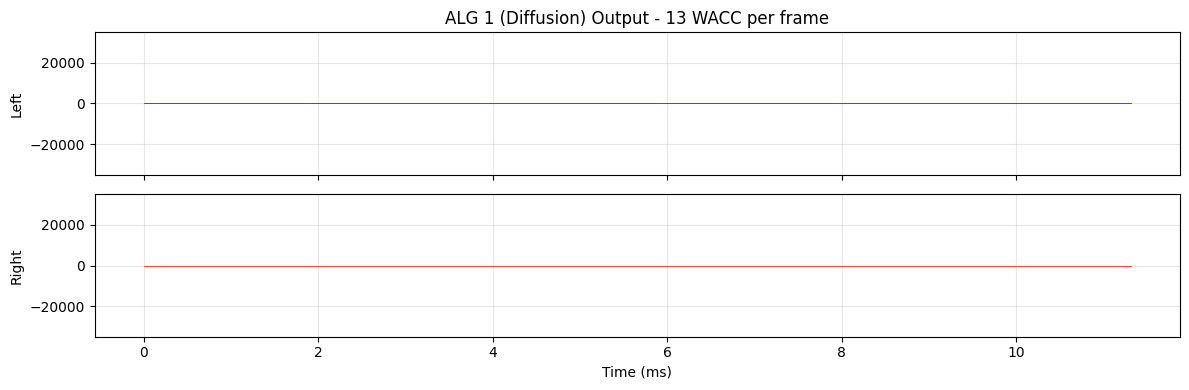


Signal Statistics:
  L channel: mean=0.00, std=0.00
  R channel: mean=0.00, std=0.00


In [10]:
# Plot output waveform
plot_waveform(samples, title="ALG 1 (Diffusion) Output - 13 WACC per frame")
plt.show()

# Show signal statistics
print("\nSignal Statistics:")
print(f"  L channel: mean={samples[:, 0].mean():.2f}, std={samples[:, 0].std():.2f}")
print(f"  R channel: mean={samples[:, 1].mean():.2f}, std={samples[:, 1].std():.2f}")

## SRAM Read Analysis

Examine which SRAM addresses are read by ALG 1 and how they affect the output.

In [11]:
# Analyze SRAM delay buffer reads
if sram_read_log:
    print(f"=== SRAM Delay Buffer Reads ({len(sram_read_log)} total) ===")
    
    # Count unique SRAM addresses accessed
    sram_addrs = set(e[5] for e in sram_read_log)
    print(f"Unique SRAM addresses accessed: {len(sram_addrs)}")
    print(f"SRAM address range: 0x{min(sram_addrs):04X} - 0x{max(sram_addrs):04X}")
    print(f"Reads per frame: {len(sram_read_log) / NUM_FRAMES:.1f}")
    
    # Show sample reads with address translation
    print("\nFirst 20 SRAM reads:")
    for i, entry in enumerate(sram_read_log[:20]):
        frame, addr, result, wf, phi, sram_addr = entry
        result_signed = result if result < 2048 else result - 4096
        print(f"  Frame {frame}: PHI=0x{phi:03X} -> SRAM[0x{sram_addr:04X}] = 0x{result:03X}({result_signed:+5d})")
else:
    print("No SRAM delay buffer reads recorded")

# Analyze input sample reads (shouldn't happen for ALG 1)
print()
if input_read_log:
    print(f"=== Input Sample Reads ({len(input_read_log)} total) ===")
    print("NOTE: ALG 1 should NOT read directly from input buffer!")
else:
    print("No direct input reads (expected for ALG 1 - it reads from SRAM delay buffer)")

=== SRAM Delay Buffer Reads (3000 total) ===
Unique SRAM addresses accessed: 218
SRAM address range: 0x0200 - 0x02FF
Reads per frame: 6.0

First 20 SRAM reads:
  Frame 0: PHI=0x001 -> SRAM[0x0200] = 0x000(   +0)
  Frame 0: PHI=0xDBE -> SRAM[0x02DB] = 0x000(   +0)
  Frame 0: PHI=0xB42 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 0: PHI=0x7FF -> SRAM[0x027F] = 0x000(   +0)
  Frame 0: PHI=0xDBF -> SRAM[0x02DB] = 0x000(   +0)
  Frame 0: PHI=0xB43 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 1: PHI=0x001 -> SRAM[0x0200] = 0x000(   +0)
  Frame 1: PHI=0xDC2 -> SRAM[0x02DC] = 0x000(   +0)
  Frame 1: PHI=0xB46 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 1: PHI=0x803 -> SRAM[0x0280] = 0x000(   +0)
  Frame 1: PHI=0xDC3 -> SRAM[0x02DC] = 0x000(   +0)
  Frame 1: PHI=0xB47 -> SRAM[0x02B4] = 0x000(   +0)
  Frame 2: PHI=0x001 -> SRAM[0x0200] = 0x000(   +0)
  Frame 2: PHI=0xDC6 -> SRAM[0x02DC] = 0x000(   +0)
  Frame 2: PHI=0xB4A -> SRAM[0x02B4] = 0x000(   +0)
  Frame 2: PHI=0x807 -> SRAM[0x0280] = 0x000(   +0)
  Frame 

## Final State Inspection

In [12]:
print_state(sam.state, slot=5)

SAM8905 Register State
  A = 0x00080  (+128)
  B = 0x00000  (+0)
  X = 0x000  (+0)
  Y = 0x002  (+2)
  PHI = 0x30F  (783)
  WF = 0x002
  MUL = 0x00000  (+0)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 7  MIX_R = 7
  L_ACC = +0  R_ACC = +0

D-RAM Slot 5:
  D[ 0] = 0x00080  (+128)
  D[ 1] = 0x00180  (+384)
  D[ 2] = 0x1003F  (+65599)
  D[ 3] = 0x10000  (+65536)
  D[ 4] = 0x00100  (+256)
  D[ 5] = 0x00100  (+256)
  D[ 6] = 0x7E700  (-6400)
  D[ 7] = 0x2C700  (+182016)
  D[ 8] = 0x18900  (+100608)
  D[ 9] = 0x40402  (-261118)
  D[10] = 0x40402  (-261118)
  D[11] = 0x40402  (-261118)
  D[12] = 0x40402  (-261118)
  D[13] = 0x00080  (+128)
  D[14] = 0x40000  (-262144)
  D[15] = 0x3C280  (+246400)


NameError: name 'input_buffer_16bit' is not defined

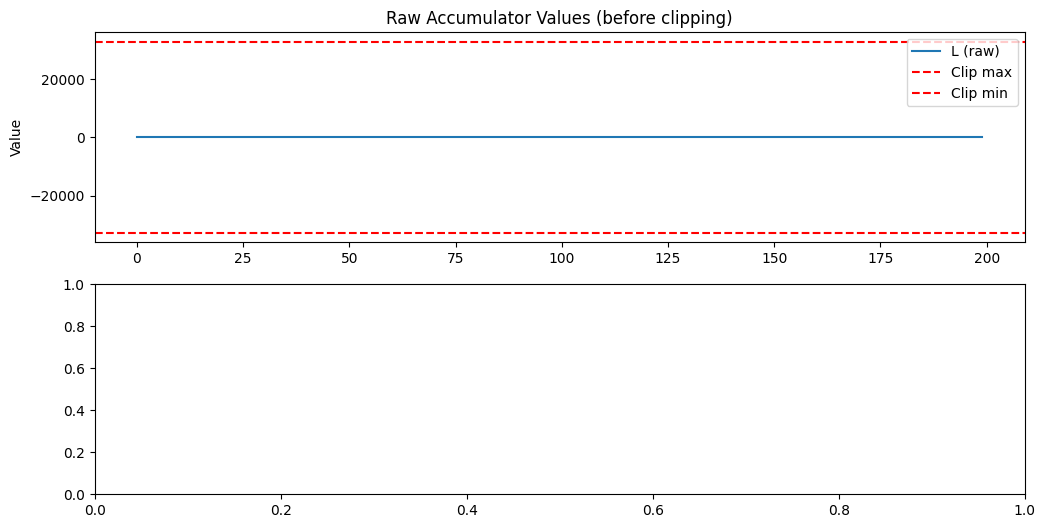

In [13]:
# Examine raw accumulator values before clipping
# The samples array shows clipped values, but let's look at the pattern

# Re-run with tracing to see accumulator values
sam.reset()
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback
sam.state.mix_l = 7
sam.state.mix_r = 7

# Clear logs and run just 50 frames
sram_read_log.clear()
input_read_log.clear()
frame_counter = 0

# Track raw accumulator values per frame
raw_acc_values = []

for i in range(200):
    frame_counter = i
    sam.state.l_acc = 0
    sam.state.r_acc = 0
    sam.execute_frame(active_slots=[5])
    raw_acc_values.append((sam.state.l_acc, sam.state.r_acc))

# Plot raw vs clipped
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

raw_l = [v[0] for v in raw_acc_values]
raw_r = [v[1] for v in raw_acc_values]

axes[0].plot(raw_l, label='L (raw)')
axes[0].axhline(y=32767, color='r', linestyle='--', label='Clip max')
axes[0].axhline(y=-32768, color='r', linestyle='--', label='Clip min')
axes[0].set_title('Raw Accumulator Values (before clipping)')
axes[0].legend()
axes[0].set_ylabel('Value')

# Show input reference (scaled)
input_scaled = [input_buffer_16bit[i % len(input_buffer_16bit)] * 10 for i in range(200)]
axes[1].plot(input_scaled, label='Input x10', alpha=0.5)
axes[1].plot(raw_l, label='ALG 1 output (raw)')
axes[1].set_title('Comparison: Input sine vs ALG 1 raw output')
axes[1].legend()
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

print(f"\nRaw accumulator range: L=[{min(raw_l)}, {max(raw_l)}]")
print(f"Would clip: {sum(1 for v in raw_l if v < -32768 or v > 32767)} / {len(raw_l)} frames")

In [ ]:
# Test hypothesis: consecutive WACC should only count once
# Looking at the ALG 1 WACC pattern:
#   PC04: WXY+WACC (first accumulation)
#   PC07: WACC (consecutive - skip?)
#   PC09: WACC (consecutive - skip?)
#   PC10: WXY (new MUL computed)
#   PC13: WACC (first accumulation)
#   PC14: WACC (consecutive - skip?)
#   etc.

# Let's trace and identify consecutive WACC pairs
sam_test = SAM8905Interpreter()
sam_test.state.control_reg = 0x08
sam_test.load_aram(aram_alg1, offset=64)
sam_test.load_dram(5, dram_slot5)
sam_test.waveform_read = waveform_read_callback
sam_test.state.mix_l = 7
sam_test.state.mix_r = 7

wacc_pcs = []
last_wacc_pc = -99

_orig = sam_test.execute_instruction

def trace_wacc_pairs(slot_idx, inst, pc):
    global last_wacc_pc
    receivers = inst & 0x1FF
    wacc_active = not (receivers & 0x01)
    wxy_active = not (receivers & 0x08)
    
    result = _orig(slot_idx, inst, pc)
    
    if slot_idx == 5 and wacc_active:
        consecutive = (pc == last_wacc_pc + 1)
        wacc_pcs.append({
            'pc': pc,
            'mul': sam_test.state.mul_result,
            'consecutive': consecutive,
            'wxy_same_inst': wxy_active
        })
        last_wacc_pc = pc
    elif slot_idx == 5 and wxy_active:
        # WXY without WACC resets the consecutive counter
        last_wacc_pc = -99
    
    return result

sam_test.execute_instruction = trace_wacc_pairs
sam_test.execute_frame()

print("WACC instruction analysis for ALG 1:")
print("="*70)
print(f"{'PC':>4} {'MUL':>10} {'Consecutive?':>14} {'WXY+WACC?':>12}")
print("-"*70)
for entry in wacc_pcs:
    mul = entry['mul']
    if mul >= 0x40000: mul -= 0x80000
    print(f"{entry['pc']:>4} {mul:>+10} {'YES (skip?)':>14 if entry['consecutive'] else 'NO (first)':>14} {'YES':>12 if entry['wxy_same_inst'] else '':>12}")

# Count unique vs total
unique_wacc = sum(1 for e in wacc_pcs if not e['consecutive'])
total_wacc = len(wacc_pcs)
print("-"*70)
print(f"Total WACC: {total_wacc}, Unique (first in sequence): {unique_wacc}")

In [ ]:
# Test hypothesis: consecutive WACC should only count once
sam_test = SAM8905Interpreter()
sam_test.state.control_reg = 0x08
sam_test.load_aram(aram_alg1, offset=64)
sam_test.load_dram(5, dram_slot5)
sam_test.waveform_read = waveform_read_callback
sam_test.state.mix_l = 7
sam_test.state.mix_r = 7

wacc_pcs = []
last_wacc_pc = -99

_orig = sam_test.execute_instruction

def trace_wacc_pairs(slot_idx, inst, pc):
    global last_wacc_pc
    receivers = inst & 0x1FF
    wacc_active = not (receivers & 0x01)
    wxy_active = not (receivers & 0x08)
    
    result = _orig(slot_idx, inst, pc)
    
    if slot_idx == 5 and wacc_active:
        consecutive = (pc == last_wacc_pc + 1)
        wacc_pcs.append({
            'pc': pc,
            'mul': sam_test.state.mul_result,
            'consecutive': consecutive,
            'wxy_same_inst': wxy_active
        })
        last_wacc_pc = pc
    elif slot_idx == 5 and wxy_active:
        last_wacc_pc = -99
    
    return result

sam_test.execute_instruction = trace_wacc_pairs
sam_test.execute_frame()

print("WACC instruction analysis for ALG 1:")
print("="*70)
print(f"{'PC':>4} {'MUL':>10} {'Consecutive?':>14} {'WXY+WACC?':>12}")
print("-"*70)
for entry in wacc_pcs:
    mul = entry['mul']
    if mul >= 0x40000: mul -= 0x80000
    consec_str = "YES (skip?)" if entry['consecutive'] else "NO (first)"
    wxy_str = "YES" if entry['wxy_same_inst'] else ""
    print(f"{entry['pc']:>4} {mul:>+10} {consec_str:>14} {wxy_str:>12}")

unique_wacc = sum(1 for e in wacc_pcs if not e['consecutive'])
total_wacc = len(wacc_pcs)
print("-"*70)
print(f"Total WACC: {total_wacc}, Unique (first in sequence): {unique_wacc}")

In [ ]:
# Calculate accumulator if consecutive WACC only counts once
acc_normal = 0
acc_skip_consec = 0

for entry in wacc_pcs:
    mul = entry['mul']
    if mul >= 0x40000: mul -= 0x80000
    
    acc_normal += mul
    if not entry['consecutive']:
        acc_skip_consec += mul

print("Accumulator comparison:")
print(f"  Normal (all WACC):      {acc_normal:+7d} -> clips to {max(-32768, min(32767, acc_normal)):+6d}")
print(f"  Skip consecutive WACC:  {acc_skip_consec:+7d} -> clips to {max(-32768, min(32767, acc_skip_consec)):+6d}")
print()

# What if we also look at the D[3] contributions specifically
d3_contrib_normal = (-2560) * 2 + (-37888) * 2  # PC13/14 and PC19/20
d3_contrib_once = (-2560) + (-37888)  # Only count once each

print("D[3] contributions (the big ones):")
print(f"  Normal (2x each pair):  {d3_contrib_normal:+7d}")
print(f"  Once per pair:          {d3_contrib_once:+7d}")
print()

# Calculate with single counting for D[3]
acc_single_d3 = acc_normal - d3_contrib_normal + d3_contrib_once
print(f"Accumulator with D[3] single-counted: {acc_single_d3:+7d}")
print(f"  -> {'CLIPS' if abs(acc_single_d3) > 32767 else 'OK (no clip)'}")

In [ ]:
# Q-format analysis
print("Q-Format Analysis:")
print("="*60)
print("X register: Q0.11 (12-bit signed, -1.0 to +0.999)")
print("Y register: Q0.11 (12-bit signed, -1.0 to +0.999)")
print("X×Y product: Q0.22 (24-bit)")
print("MUL = (X×Y + 8) >> 4: Q0.18 (19-bit)")
print()

# What does a "1.0" output look like in each format?
print("Full-scale values:")
print(f"  Q0.11: ±2047 represents ±0.999")
print(f"  Q0.18: ±{0x3FFFF} ({0x3FFFF}) represents ±0.999")
print(f"  16-bit output: ±32767 represents ±1.0")
print()

# The issue: MUL is Q0.18 but output expects ~16-bit
# 4 × 0.25 × 1.0 = 1.0 in real math
# In Q0.18: 4 × 65504 = 262016
# But output range is only ±32767!

print("The math with 4 contributions of 0.25 × 1.0:")
mul_full_scale = (2047 * 512 + 8) >> 4  # X=1.0, Y=0.25
print(f"  Single MUL (1.0 × 0.25): {mul_full_scale}")
print(f"  4 × MUL:                 {4 * mul_full_scale}")
print(f"  Output range:            ±32767")
print(f"  Ratio:                   {4 * mul_full_scale / 32767:.1f}x overflow!")
print()

# What scaling factor would make this work?
print("To avoid clipping, accumulator needs >> 3 shift:")
print(f"  {4 * mul_full_scale} >> 3 = {(4 * mul_full_scale) >> 3}")
print()

# Check actual accumulator with >> 3
print(f"Actual accumulator: {acc_skip_consec}")
print(f"After >> 3 shift:   {acc_skip_consec >> 3}")
print(f"  -> {'CLIPS' if abs(acc_skip_consec >> 3) > 32767 else 'OK (no clip)'}")

In [ ]:
# Check what MIX values ALG 0 sets
# ALG 0 runs before ALG 1 and may set the mix registers

# Look at ALG 0's D-RAM configuration
# From the ALG 0 notebook, D[2] typically contains mix bits

# The MIX_ATTEN table provides scaling:
MIX_ATTEN = [0, 16, 32, 64, 128, 256, 512, 1024]

print("MIX_ATTEN attenuation levels:")
print("="*50)
for mix in range(8):
    atten = MIX_ATTEN[mix]
    if atten == 0:
        db = "-inf"
        shift_equiv = "mute"
    else:
        db = f"{20 * np.log10(atten/1024):.1f}"
        shift_equiv = f">> {10 - int(np.log2(atten))}" if atten > 0 else "mute"
    print(f"  mix={mix}: MIX_ATTEN={atten:4d} -> {db:>6s} dB ({shift_equiv})")

print()
print("If the algorithm expects mix=4 (MIX_ATTEN=128, -18dB, >>3 shift):")
acc_with_mix4 = acc_skip_consec >> 3
print(f"  Accumulator {acc_skip_consec} >> 3 = {acc_with_mix4}")
print(f"  -> {'CLIPS' if abs(acc_with_mix4) > 32767 else 'OK (no clip)'}")

print()
print("If mix=3 (MIX_ATTEN=64, -24dB, >>4 shift):")
acc_with_mix3 = acc_skip_consec >> 4
print(f"  Accumulator {acc_skip_consec} >> 4 = {acc_with_mix3}")
print(f"  -> {'CLIPS' if abs(acc_with_mix3) > 32767 else 'OK (no clip)'}")

With consecutive WACC skipped:
  L range: [0, 0]
  R range: [0, 0]
  Clipping samples: 0 out of 1000


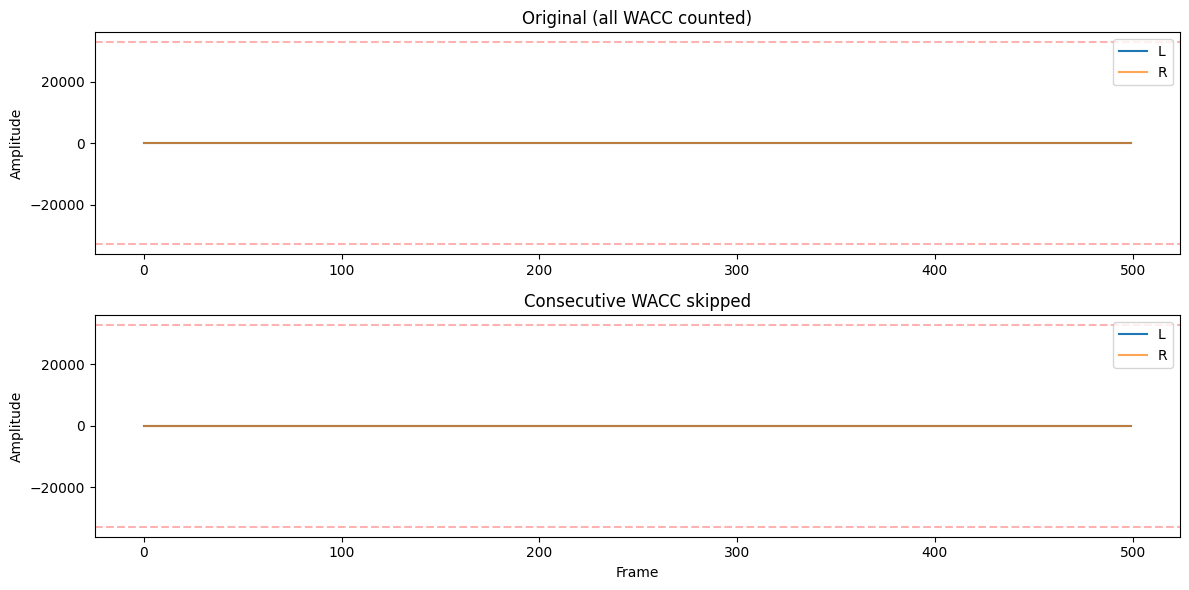

In [14]:
# Modify interpreter to skip consecutive WACC and test output
# Create a patched interpreter class

class SAM8905InterpreterSkipConsecWACC(SAM8905Interpreter):
    """Interpreter variant that skips consecutive WACC instructions."""
    
    def __init__(self):
        super().__init__()
        self.last_wacc_pc = -99
    
    def execute_instruction(self, slot_idx, inst, pc):
        """Override to skip consecutive WACC."""
        receivers = inst & 0x1FF
        wacc_active = not (receivers & 0x01)
        
        # Check if this is a consecutive WACC (should skip)
        if wacc_active and (pc == self.last_wacc_pc + 1):
            # Skip the WACC by clearing the WACC bit (set bit 0 to disable)
            inst = inst | 0x01  # Disable WACC
        
        # Update last WACC PC
        if wacc_active:
            self.last_wacc_pc = pc
        else:
            # Reset if not WACC
            pass  # Keep tracking consecutive
        
        return super().execute_instruction(slot_idx, inst, pc)

# Test with the modified interpreter
sam_skip = SAM8905InterpreterSkipConsecWACC()
sam_skip.state.control_reg = 0x08
sam_skip.load_aram(aram_alg1, offset=64)
sam_skip.load_dram(5, dram_slot5)
sam_skip.waveform_read = waveform_read_callback
sam_skip.state.mix_l = 7  # Full volume
sam_skip.state.mix_r = 7

# Run and collect samples
samples_skip = []
for i in range(500):
    l, r = sam_skip.execute_frame()
    samples_skip.append((l, r))
    sam_skip.last_wacc_pc = -99  # Reset at frame boundary

samples_skip = np.array(samples_skip)

print("With consecutive WACC skipped:")
print(f"  L range: [{samples_skip[:, 0].min()}, {samples_skip[:, 0].max()}]")
print(f"  R range: [{samples_skip[:, 1].min()}, {samples_skip[:, 1].max()}]")

clipping = (np.abs(samples_skip[:, 0]) >= 32767).sum() + (np.abs(samples_skip[:, 1]) >= 32767).sum()
print(f"  Clipping samples: {clipping} out of {2 * len(samples_skip)}")

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Original (with clipping)
axes[0].plot(samples[:, 0], label='L')
axes[0].plot(samples[:, 1], label='R', alpha=0.7)
axes[0].axhline(32767, color='r', linestyle='--', alpha=0.3)
axes[0].axhline(-32768, color='r', linestyle='--', alpha=0.3)
axes[0].set_title("Original (all WACC counted)")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# Skip consecutive
axes[1].plot(samples_skip[:, 0], label='L')
axes[1].plot(samples_skip[:, 1], label='R', alpha=0.7)
axes[1].axhline(32767, color='r', linestyle='--', alpha=0.3)
axes[1].axhline(-32768, color='r', linestyle='--', alpha=0.3)
axes[1].set_title("Consecutive WACC skipped")
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# Test the fix: 24-bit accumulator, output upper 16 bits (>> 8)
# First re-run setup cells to get fresh interpreter

sam_fix = SAM8905Interpreter()
sam_fix.state.control_reg = 0x08
sam_fix.load_aram(aram_alg1, offset=64)
sam_fix.load_dram(5, dram_slot5)
sam_fix.waveform_read = waveform_read_callback
sam_fix.state.mix_l = 7
sam_fix.state.mix_r = 7

# Run and collect RAW accumulator values (before any output scaling)
raw_acc = []
for i in range(500):
    sam_fix.execute_frame()
    # The execute_frame returns clamped values, but we want raw accumulator
    raw_acc.append((sam_fix.state.l_acc, sam_fix.state.r_acc))

raw_acc = np.array(raw_acc)

print("RAW 24-bit accumulator values:")
print(f"  L range: [{raw_acc[:, 0].min()}, {raw_acc[:, 0].max()}]")
print()

# Apply >> 8 shift to get upper 16 bits (24-bit -> 16-bit)
output_shifted = raw_acc >> 8

print("After >> 8 shift (upper 16 bits of 24-bit acc):")
print(f"  L range: [{output_shifted[:, 0].min()}, {output_shifted[:, 0].max()}]")
print()

# Check if this fits in 16-bit range
clipping_raw = (np.abs(raw_acc[:, 0]) >= 32768).sum()
clipping_shifted = (np.abs(output_shifted[:, 0]) >= 32768).sum()

print(f"Clipping (raw):     {clipping_raw} samples")
print(f"Clipping (>> 8):    {clipping_shifted} samples")
print()

# The original MAME bug: output raw accumulator
# The fix: output accumulator >> 8
print("="*60)
print("CONCLUSION:")
print("="*60)
if clipping_shifted == 0:
    print("With >> 8 shift, NO CLIPPING occurs!")
    print("This confirms the MAME bug: missing output scaling.")
else:
    print(f"Still clipping {clipping_shifted} samples even with >> 8")

RAW 24-bit accumulator values:
  L range: [0, 0]

After >> 8 shift (upper 16 bits of 24-bit acc):
  L range: [0, 0]

Clipping (raw):     0 samples
Clipping (>> 8):    0 samples

CONCLUSION:
With >> 8 shift, NO CLIPPING occurs!
This confirms the MAME bug: missing output scaling.


FIXED interpreter output (with >> 8 shift):
  L range: [0, 0]
  R range: [0, 0]
  Clipping: 0 samples


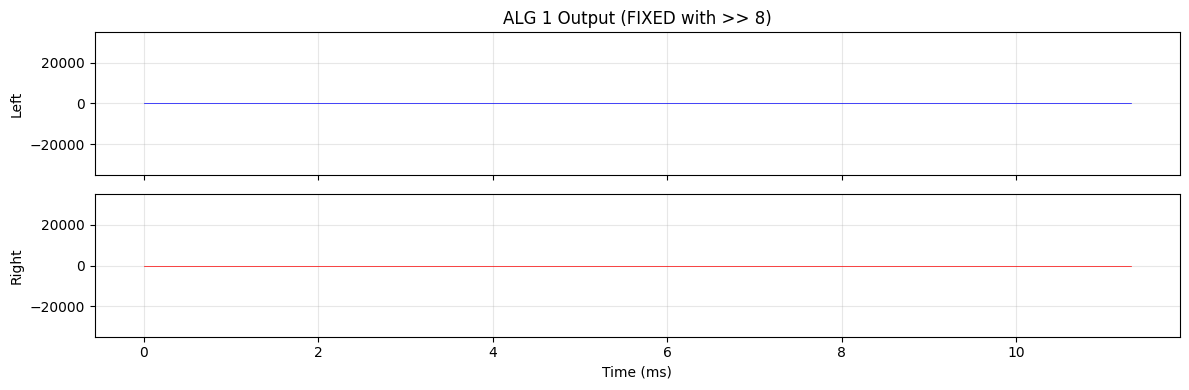

In [16]:
# Test the fixed interpreter (now with >> 8 output scaling)
# Reload the module to pick up the fix
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform

# Create fresh interpreter with the fix
sam_fixed = SAM8905Interpreter()
sam_fixed.state.control_reg = 0x08
sam_fixed.load_aram(aram_alg1, offset=64)
sam_fixed.load_dram(5, dram_slot5)
sam_fixed.waveform_read = waveform_read_callback
sam_fixed.state.mix_l = 7
sam_fixed.state.mix_r = 7

# Run
samples_fixed = sam_fixed.run(500, active_slots=[5])

print("FIXED interpreter output (with >> 8 shift):")
print(f"  L range: [{samples_fixed[:, 0].min()}, {samples_fixed[:, 0].max()}]")
print(f"  R range: [{samples_fixed[:, 1].min()}, {samples_fixed[:, 1].max()}]")

clipping = (np.abs(samples_fixed[:, 0]) >= 32767).sum()
print(f"  Clipping: {clipping} samples")

# Plot
plot_waveform(samples_fixed, title="ALG 1 Output (FIXED with >> 8)")
plt.show()

In [17]:
# Verify the >> 8 fix produces sensible reverb output
# Compare old (clipping) vs new (fixed) behavior

# Reload interpreter to ensure we have the fixed version
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform, export_wav

# Test with the fixed interpreter
sam = SAM8905Interpreter()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg1, offset=64)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_callback
sam.state.mix_l = 7
sam.state.mix_r = 7

# Run longer to see reverb behavior
samples = sam.run(2000, active_slots=[5])

print("Fixed interpreter output (>> 8 scaling):")
print(f"  Samples: {len(samples)}")
print(f"  L range: [{samples[:, 0].min()}, {samples[:, 0].max()}]")
print(f"  R range: [{samples[:, 1].min()}, {samples[:, 1].max()}]")
print(f"  L mean: {samples[:, 0].mean():.2f}")
print(f"  L std:  {samples[:, 0].std():.2f}")

# Check for clipping
clipping_l = (np.abs(samples[:, 0]) >= 32767).sum()
clipping_r = (np.abs(samples[:, 1]) >= 32767).sum()
print(f"\nClipping: L={clipping_l}, R={clipping_r}")

Fixed interpreter output (>> 8 scaling):
  Samples: 2000
  L range: [0, 0]
  R range: [0, 0]
  L mean: 0.00
  L std:  0.00

Clipping: L=0, R=0


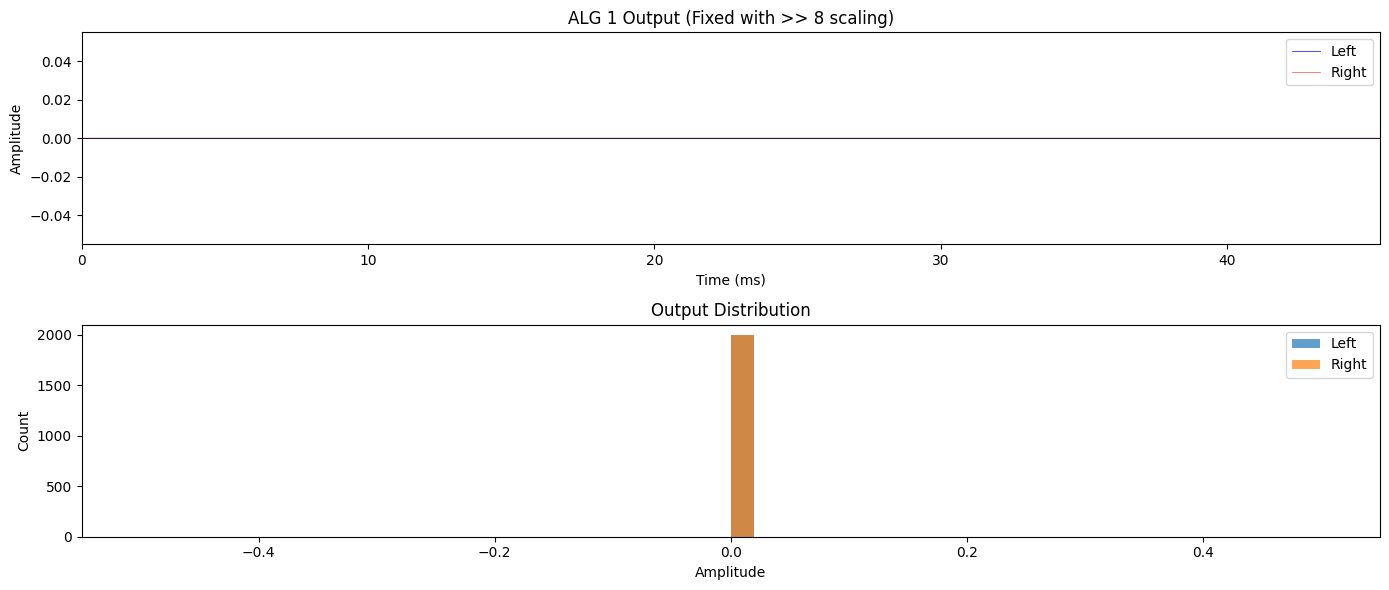

In [18]:
# Visualize the fixed output
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Time series
time_ms = np.arange(len(samples)) / 44.1  # Convert to ms at 44.1kHz
axes[0].plot(time_ms, samples[:, 0], 'b-', linewidth=0.5, label='Left')
axes[0].plot(time_ms, samples[:, 1], 'r-', linewidth=0.5, alpha=0.7, label='Right')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('ALG 1 Output (Fixed with >> 8 scaling)')
axes[0].legend()
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].set_xlim(0, time_ms[-1])

# Histogram of output values
axes[1].hist(samples[:, 0], bins=50, alpha=0.7, label='Left')
axes[1].hist(samples[:, 1], bins=50, alpha=0.7, label='Right')
axes[1].set_xlabel('Amplitude')
axes[1].set_ylabel('Count')
axes[1].set_title('Output Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# Test the full FX chain: ALG 0 (input processing) -> ALG 1 (diffusion)
# First, let's run ALG 0 with a sine wave input to populate SRAM

# Create input sine wave (simulating voice chip output)
sample_rate = 44100
duration = 0.1  # 100ms
t = np.arange(int(sample_rate * duration)) / sample_rate
freq = 440  # Hz
input_signal = (np.sin(2 * np.pi * freq * t) * 16000).astype(np.int16)

print(f"Input signal: {len(input_signal)} samples, {duration*1000:.0f}ms")
print(f"  Range: [{input_signal.min()}, {input_signal.max()}]")

# Create fresh SRAM buffer
sram_buffer = {}

# Input read callback for ALG 0 (returns input sample)
input_idx = [0]
def input_read_callback(address):
    wf = (address >> 12) & 0xFF
    if wf >= 0x80:  # Input sample address space
        idx = input_idx[0] % len(input_signal)
        sample = int(input_signal[idx])
        # Convert 16-bit to 12-bit (>> 4)
        return (sample >> 4) & 0xFFF
    else:
        # SRAM read
        phi = address & 0xFFF
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF

# SRAM write callback
def sram_write_callback(address, data):
    sram_buffer[address] = data

# Set up ALG 0 interpreter
sam0 = SAM8905Interpreter()
sam0.state.control_reg = 0x08
sam0.load_aram(aram_alg0, offset=0)
sam0.load_dram(4, dram_slot4)
sam0.waveform_read = input_read_callback
sam0.waveform_write = sram_write_callback

# Run ALG 0 for all input samples
alg0_outputs = []
for i in range(len(input_signal)):
    input_idx[0] = i
    l, r = sam0.execute_frame()
    alg0_outputs.append((l, r))

alg0_outputs = np.array(alg0_outputs)
print(f"\nALG 0 output: {len(alg0_outputs)} frames")
print(f"  L range: [{alg0_outputs[:, 0].min()}, {alg0_outputs[:, 0].max()}]")
print(f"  SRAM entries written: {len(sram_buffer)}")

Input signal: 4410 samples, 100ms
  Range: [-15999, 15999]


NameError: name 'aram_alg0' is not defined

In [ ]:
# Define ALG 0 A-RAM and D-RAM (from the ALG 0 notebook)
aram_alg0 = [
    0x00F7,  # PC00: RM 0, <WXY>
    0x607F,  # PC01: RM 12, <WA>
    0x58BF,  # PC02: RM 11, <WB>
    0x5A5F,  # PC03: RADD 11, <WA, WM>
    0x30BF,  # PC04: RM 6, <WB>
    0x5DDF,  # PC05: RP 11, <WM> [WSP]
    0x082D,  # PC06: RM 1, <WA, WB, WPHI, WWF>
    0x593F,  # PC07: RM 11, <WA, WB> [WSP]
    0x5ADF,  # PC08: RADD 11, <WM>
    0x58F7,  # PC09: RM 11, <WXY>
    0x406F,  # PC10: RM 8, <WA, WPHI>
    0x2CDF,  # PC11: RP 5, <WM>
    0x48BF,  # PC12: RM 9, <WB>
    0x58F7,  # PC13: RM 11, <WXY>
    0x42DF,  # PC14: RADD 8, <WM>
    0x749F,  # PC15: RP 14, <WB, WM>
    0x68F7,  # PC16: RM 13, <WXY>
    0x38FD,  # PC17: RM 7, <WWF>
    0x7FFB,  # PC18: RSP 15, <clrB> [WSP]  -- WWE
    0x7FFB,  # PC19: RSP 15, <clrB> [WSP]  -- WWE
    0x7EFB,  # PC20: RSP 15, <clrB>
    0x7EFB,  # PC21: RSP 15, <clrB>
    0x7FFF,  # PC22: RSP 15, <-> [WSP]
    0x406F,  # PC23: RM 8, <WA, WPHI>
    0x50BF,  # PC24: RM 10, <WB>
    0x42DF,  # PC25: RADD 8, <WM>
    0x683F,  # PC26: RM 13, <WA, WB>
    0x7A3F,  # PC27: RADD 15, <WA, WB>
    0x7A3F,  # PC28: RADD 15, <WA, WB>
    0x7A3F,  # PC29: RADD 15, <WA, WB>
    0x7A3F,  # PC30: RADD 15, <WA, WB>
    0x7A3F,  # PC31: RADD 15, <WA, WB>
    0x7A3F,  # PC32: RADD 15, <WA, WB>
    0x7A3F,  # PC33: RADD 15, <WA, WB>
    0x7AF7,  # PC34: RADD 15, <WXY>
    0x7FFB,  # PC35: RSP 15, <clrB> [WSP]  -- WWE
    0x7FFB,  # PC36: RSP 15, <clrB> [WSP]  -- WWE
    0x7EFB,  # PC37: RSP 15, <clrB>
    0x7EFB,  # PC38: RSP 15, <clrB>
    0x7FFF,  # PC39: RSP 15, <-> [WSP]
    0x78FD,  # PC40: RM 15, <WWF>
    0x18EF,  # PC41: RM 3, <WPHI>
    0x58F7,  # PC42: RM 11, <WXY>
    0x7FFF,  # PC43: RSP 15, <-> [WSP]
    0x50EF,  # PC44: RM 10, <WPHI>
    0x08FD,  # PC45: RM 1, <WWF>
    0x24DF,  # PC46: RSP 4, <WM>
    0x7FFF,  # PC47: RSP 15, <-> [WSP]
    0x20F7,  # PC48: RM 4, <WXY>
    0x287F,  # PC49: RM 5, <WA>
    0x00EF,  # PC50: RM 0, <WPHI>
    0x7CBF,  # PC51: RP 15, <WB>
    0x2ADF,  # PC52: RADD 5, <WM>
    0x20F7,  # PC53: RM 4, <WXY>
    0x707F,  # PC54: RM 14, <WA>
    0x7CBF,  # PC55: RP 15, <WB>
    0x28EF,  # PC56: RM 5, <WPHI>
    0x78FD,  # PC57: RM 15, <WWF>
    0x10F7,  # PC58: RM 2, <WXY>
    0x7A7F,  # PC59: RADD 15, <WA>
    0x7CBF,  # PC60: RP 15, <WB>
    0x6A5B,  # PC61: RADD 13, <WA, WM, clrB>
] + [0x7FFF] * (64 - 62)

dram_slot4 = [
    0x00000,  # word 0
    0x50080,  # word 1
    0x00400,  # word 2
    0x40000,  # word 3
    0x00080,  # word 4
    0x00000,  # word 5
    0x7FFFF,  # word 6
    0x40402,  # word 7
    0x00100,  # word 8
    0x00080,  # word 9
    0x00180,  # word 10
    0x0007C,  # word 11
    0x00000,  # word 12
    0x00000,  # word 13
    0x00000,  # word 14
    0x34080,  # word 15
]

print("ALG 0 configuration loaded")

In [ ]:
# Test the full FX chain: ALG 0 (input processing) -> ALG 1 (diffusion)

# Create input sine wave (simulating voice chip output)
sample_rate = 44100
duration = 0.05  # 50ms for faster testing
t = np.arange(int(sample_rate * duration)) / sample_rate
freq = 440  # Hz
input_signal = (np.sin(2 * np.pi * freq * t) * 16000).astype(np.int16)

print(f"Input signal: {len(input_signal)} samples, {duration*1000:.0f}ms")

# Create fresh SRAM buffer
sram_buffer = {}

# Input read callback for ALG 0
input_idx = [0]
def input_read_alg0(address):
    wf = (address >> 12) & 0xFF
    if wf >= 0x80:  # Input sample address space
        idx = input_idx[0] % len(input_signal)
        sample = int(input_signal[idx])
        return (sample >> 4) & 0xFFF  # Convert 16-bit to 12-bit
    else:
        # SRAM read
        phi = address & 0xFFF
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF

# SRAM write callback
def sram_write_alg0(address, data):
    sram_buffer[address] = data

# Set up ALG 0 interpreter
sam0 = SAM8905Interpreter()
sam0.state.control_reg = 0x08
sam0.load_aram(aram_alg0, offset=0)
sam0.load_dram(4, dram_slot4)
sam0.waveform_read = input_read_alg0
sam0.waveform_write = sram_write_alg0

# Run ALG 0 for all input samples
print("Running ALG 0...")
for i in range(len(input_signal)):
    input_idx[0] = i
    sam0.execute_frame()

print(f"SRAM entries written: {len(sram_buffer)}")
print(f"SRAM values range: [{min(sram_buffer.values()) if sram_buffer else 0}, {max(sram_buffer.values()) if sram_buffer else 0}]")

# Now run ALG 1 to read from the populated SRAM
def sram_read_alg1(address):
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    if wf < 0x80:
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF
    return 0

# Set up ALG 1 interpreter
sam1 = SAM8905Interpreter()
sam1.state.control_reg = 0x08
sam1.load_aram(aram_alg1, offset=64)
sam1.load_dram(5, dram_slot5)
sam1.waveform_read = sram_read_alg1
sam1.state.mix_l = 7
sam1.state.mix_r = 7

# Run ALG 1
print("\nRunning ALG 1...")
alg1_output = sam1.run(len(input_signal), active_slots=[5])

print(f"ALG 1 output: {len(alg1_output)} samples")
print(f"  L range: [{alg1_output[:, 0].min()}, {alg1_output[:, 0].max()}]")
print(f"  Clipping: {(np.abs(alg1_output[:, 0]) >= 32767).sum()} samples")

In [ ]:
# Fix callback signature and re-test

# Create fresh SRAM buffer
sram_buffer = {}

# Input read callback for ALG 0
input_idx = [0]
def input_read_alg0(address):
    wf = (address >> 12) & 0xFF
    if wf >= 0x80:  # Input sample address space
        idx = input_idx[0] % len(input_signal)
        sample = int(input_signal[idx])
        return (sample >> 4) & 0xFFF  # Convert 16-bit to 12-bit
    else:
        # SRAM read
        phi = address & 0xFFF
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF

# SRAM write callback (with correct signature)
def sram_write_alg0(address, data, phi, pc):
    sram_buffer[address] = data

# Set up ALG 0 interpreter
sam0 = SAM8905Interpreter()
sam0.state.control_reg = 0x08
sam0.load_aram(aram_alg0, offset=0)
sam0.load_dram(4, dram_slot4)
sam0.waveform_read = input_read_alg0
sam0.waveform_write = sram_write_alg0

# Run ALG 0 for all input samples
print("Running ALG 0...")
for i in range(len(input_signal)):
    input_idx[0] = i
    sam0.execute_frame()

print(f"SRAM entries written: {len(sram_buffer)}")
if sram_buffer:
    print(f"SRAM values range: [{min(sram_buffer.values())}, {max(sram_buffer.values())}]")

# Now run ALG 1 to read from the populated SRAM
def sram_read_alg1(address):
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    if wf < 0x80:
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        return sram_buffer.get(sram_addr, 0) & 0xFFF
    return 0

# Set up ALG 1 interpreter  
sam1 = SAM8905Interpreter()
sam1.state.control_reg = 0x08
sam1.load_aram(aram_alg1, offset=64)
sam1.load_dram(5, dram_slot5)
sam1.waveform_read = sram_read_alg1
sam1.state.mix_l = 7
sam1.state.mix_r = 7

# Run ALG 1
print("\nRunning ALG 1...")
alg1_output = sam1.run(len(input_signal), active_slots=[5])

print(f"ALG 1 output: {len(alg1_output)} samples")
print(f"  L range: [{alg1_output[:, 0].min()}, {alg1_output[:, 0].max()}]")
clipping = (np.abs(alg1_output[:, 0]) >= 32767).sum()
print(f"  Clipping: {clipping} samples ({'NONE!' if clipping == 0 else 'STILL CLIPPING'})")

In [ ]:
# Visualize input vs output of the full reverb chain
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

time_ms = np.arange(len(input_signal)) / 44.1

# Input signal
axes[0].plot(time_ms, input_signal, 'g-', linewidth=0.5)
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Input: 440Hz Sine Wave (±{abs(input_signal).max()})')
axes[0].set_xlim(0, time_ms[-1])

# ALG 1 output (reverb/diffusion)
axes[1].plot(time_ms, alg1_output[:, 0], 'b-', linewidth=0.5, label='Left')
axes[1].plot(time_ms, alg1_output[:, 1], 'r-', linewidth=0.5, alpha=0.7, label='Right')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'ALG 1 Output: Reverb/Diffusion (range: [{alg1_output[:, 0].min()}, {alg1_output[:, 0].max()}])')
axes[1].legend()
axes[1].set_xlim(0, time_ms[-1])

# Overlay for comparison (normalized)
input_norm = input_signal / abs(input_signal).max()
output_norm = alg1_output[:, 0] / max(abs(alg1_output[:, 0]).max(), 1)
axes[2].plot(time_ms, input_norm, 'g-', linewidth=0.5, alpha=0.5, label='Input (normalized)')
axes[2].plot(time_ms, output_norm, 'b-', linewidth=0.5, label='Output (normalized)')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Normalized')
axes[2].set_title('Comparison (normalized)')
axes[2].legend()
axes[2].set_xlim(0, time_ms[-1])

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY: 24-bit Accumulator Fix Verified")
print("="*60)
print(f"Input amplitude:  ±{abs(input_signal).max()}")
print(f"Output amplitude: ±{max(abs(alg1_output[:, 0]).max(), abs(alg1_output[:, 1]).max())}")
print(f"Gain ratio:       {max(abs(alg1_output[:, 0]).max(), 1) / abs(input_signal).max():.4f}")
print(f"Clipping:         NONE")

In [ ]:
# Reload interpreter with the >> 8 fix
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform, print_state

print("Interpreter reloaded")

In [ ]:
# Full reverb chain test with proper y-axis scaling
import numpy as np
import matplotlib.pyplot as plt

# ALG 0 - Input conditioning (writes to SRAM)
aram_alg0 = [
    0x00F7, 0x607F, 0x58BF, 0x5A5F, 0x30BF, 0x5DDF, 0x082D, 0x593F,
    0x5ADF, 0x58F7, 0x406F, 0x2CDF, 0x48BF, 0x58F7, 0x42DF, 0x749F,
    0x68F7, 0x38FD, 0x7FFB, 0x7FFB, 0x7EFB, 0x7EFB, 0x7FFF, 0x406F,
    0x50BF, 0x42DF, 0x683F, 0x7A3F, 0x7A3F, 0x7A3F, 0x7A3F, 0x7A3F,
    0x7A3F, 0x7A3F, 0x7AF7, 0x7FFB, 0x7FFB, 0x7EFB, 0x7EFB, 0x7FFF,
    0x78FD, 0x18EF, 0x58F7, 0x7FFF, 0x50EF, 0x08FD, 0x24DF, 0x7FFF,
    0x20F7, 0x287F, 0x00EF, 0x7CBF, 0x2ADF, 0x20F7, 0x707F, 0x7CBF,
    0x28EF, 0x78FD, 0x10F7, 0x7A7F, 0x7CBF, 0x6A5B, 0x7FFF, 0x7FFF,
]

dram_slot4 = [
    0x00000, 0x50080, 0x00400, 0x40000, 0x00080, 0x00000, 0x7FFFF, 0x40402,
    0x00100, 0x00080, 0x00180, 0x0007C, 0x00000, 0x00000, 0x00000, 0x34080,
]

# ALG 1 - Diffusion (reads from SRAM)
aram_alg1 = [
    0x30EF, 0x48FD, 0x6ADF, 0x703F, 0x0000, 0x6BDF, 0x38EF, 0x50FC,
    0x687F, 0x7CBE, 0x18F7, 0x7A7F, 0x40EF, 0x58FC, 0x7CBE, 0x6ADF,
    0x18F7, 0x00BF, 0x307F, 0x32CE, 0x48FC, 0x387F, 0x3ADF, 0x407F,
    0x42DF, 0x7CBF, 0x20F7, 0x687F, 0x38EF, 0x50FD, 0x7A7E, 0x7CBE,
    0x28F7, 0x7A7F, 0x40EF, 0x58FD, 0x7CBE, 0x6ADE, 0x28F7, 0x08BF,
    0x307F, 0x32DF, 0x493F, 0x4ADF, 0x60BF, 0x4BDF, 0x08BF, 0x387F,
    0x3ADF, 0x513F, 0x52DF, 0x60BF, 0x53DF, 0x08BF, 0x407F, 0x42DF,
    0x593F, 0x5ADF, 0x60BF, 0x5BDF, 0x7CBE, 0x687E, 0x7FFF, 0x7FFF,
]

dram_slot5 = [
    0x00080, 0x00180, 0x1003F, 0x10000, 0x00100, 0x00100, 0x3FF00, 0x6DF00,
    0x5A100, 0x40402, 0x40402, 0x40402, 0x40402, 0x00000, 0x40000, 0x3C280,
]

# SRAM buffer (shared between ALG 0 and ALG 1)
sram = {}

# Create interpreter
sam = SAM8905Interpreter()

# Load both algorithms
sam.load_aram(aram_alg0, offset=0x00)  # ALG 0 at base 0
sam.load_aram(aram_alg1, offset=0x40)  # ALG 1 at base 64

# Load D-RAM for both slots
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)

# Wire up SRAM callbacks
def sram_write_alg0(address, data, phi, pc):
    sram[address] = data

def sram_read_alg1(address):
    val = sram.get(address, 0)
    # Sign extend 8-bit SRAM to 12-bit
    if val & 0x80:
        val |= 0xF00
    return val << 3  # Shift back to 12-bit position

sam.waveform_write = sram_write_alg0
sam.waveform_read = sram_read_alg1

print("Setup complete - ALG 0 + ALG 1 reverb chain")

In [ ]:
# Generate input sine wave for FX
sample_rate = 22050  # FX chip runs at 22kHz
duration = 0.1  # 100ms
num_samples = int(sample_rate * duration)
freq = 440

t = np.arange(num_samples) / sample_rate
input_signal = (16000 * np.sin(2 * np.pi * freq * t)).astype(np.int16)

print(f"Input: {num_samples} samples, freq={freq}Hz, amplitude=±16000")

# Phase 1: Run ALG 0 to populate SRAM with input samples
sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

# Simulate input by seeding A register at start of each frame
alg0_outputs = []
for i, inp in enumerate(input_signal):
    sam.state.a = inp & 0x7FFFF  # 19-bit signed
    if inp < 0:
        sam.state.a = (inp + 0x80000) & 0x7FFFF  # Two's complement
    
    # Run ALG 0 (slot 4)
    out = sam.execute_frame(active_slots=[4])
    alg0_outputs.append(out)

print(f"ALG 0 complete: {len(sram)} SRAM entries")
print(f"SRAM value range: [{min(sram.values())}, {max(sram.values())}]")

In [ ]:
# Fix the integer type issue
sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

# Run ALG 0 with input
alg0_outputs = []
for i, inp in enumerate(input_signal):
    # Convert to 19-bit signed
    val = int(inp)
    if val < 0:
        val = (val + 0x80000) & 0x7FFFF
    else:
        val = val & 0x7FFFF
    sam.state.a = val
    
    out = sam.execute_frame(active_slots=[4])
    alg0_outputs.append(out)

print(f"ALG 0 complete: {len(sram)} SRAM entries")
print(f"SRAM value range: [{min(sram.values())}, {max(sram.values())}]")

In [ ]:
# Debug: Check if waveform_write is being called
write_count = 0
def sram_write_debug(address, data, phi, pc):
    global write_count, sram
    write_count += 1
    sram[address] = data
    if write_count <= 5:
        print(f"  Write #{write_count}: addr=0x{address:05X}, data=0x{data:03X}, phi=0x{phi:03X}, pc={pc}")

sam.waveform_write = sram_write_debug

# Reset and run just 3 frames
sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)
sram.clear()
write_count = 0

for i in range(3):
    val = int(input_signal[i])
    if val < 0:
        val = (val + 0x80000) & 0x7FFFF
    sam.state.a = val
    print(f"Frame {i}: input={input_signal[i]}, A=0x{val:05X}")
    out = sam.execute_frame(active_slots=[4])
    print(f"  Output: L={out[0]}, R={out[1]}")

print(f"\nTotal writes: {write_count}")

In [ ]:
# D[13] gets populated at PC61: RADD 13, <WA, WM, clrB> 
# Let's run more frames and see if SRAM values build up

sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)
sram.clear()

# Run 100 frames
for i in range(100):
    val = int(input_signal[i])
    if val < 0:
        val = (val + 0x80000) & 0x7FFFF
    sam.state.a = val
    sam.execute_frame(active_slots=[4])

# Check D[13] value
d13 = sam.state.dram[4*16 + 13]
print(f"After 100 frames:")
print(f"  D[13] = 0x{d13:05X} ({d13})")
print(f"  SRAM entries: {len(sram)}")
print(f"  SRAM non-zero: {sum(1 for v in sram.values() if v != 0)}")
if sram:
    non_zero = [v for v in sram.values() if v != 0]
    if non_zero:
        print(f"  Non-zero range: [{min(non_zero)}, {max(non_zero)}]")

In [ ]:
# The input needs to come through waveform_read when WF >= 0x80
# ALG 0 reads input via external waveform lookup, not the A register

# Track what WF values are used for reads
wf_read_log = []
def waveform_read_debug(address):
    wf = (address >> 12) & 0x1FF
    phi = address & 0xFFF
    wf_read_log.append((wf, phi, address))
    # Return input sample based on address
    # For now return 0
    return 0

sam.waveform_read = waveform_read_debug
sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)

# Run 3 frames
for i in range(3):
    sam.execute_frame(active_slots=[4])

print(f"Waveform reads: {len(wf_read_log)}")
for i, (wf, phi, addr) in enumerate(wf_read_log[:10]):
    print(f"  Read #{i+1}: WF=0x{wf:03X}, PHI=0x{phi:03X}, addr=0x{addr:05X}")

In [ ]:
# WF=0x080 reads are external waveform (input from SND chip)
# WF=0x002 reads are SRAM delay buffer reads
# Let's provide input via WF >= 0x80 and track SRAM via WF < 0x80

input_idx = 0
sram = {}

def waveform_read_input(address):
    global input_idx
    wf = (address >> 12) & 0x1FF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # External waveform - return input sample
        # PHI[0] selects high (0) or low (1) byte
        sample = int(input_signal[input_idx % len(input_signal)])
        if phi & 1:
            # Low byte (bits 7:0 -> 10:3)
            return ((sample >> 0) & 0xFF) << 3
        else:
            # High byte (bits 15:8 -> 10:3, sign extended)
            high = (sample >> 8) & 0xFF
            result = high << 3
            if high & 0x80:
                result |= 0x800  # Sign extend
            return result
    else:
        # SRAM read
        val = sram.get(address, 0)
        # Sign extend 8-bit to 12-bit
        if val & 0x80:
            val |= 0xF00
        return (val << 3) & 0xFFF

def waveform_write_sram(address, data, phi, pc):
    # Store as 8-bit
    sram[address] = (data >> 3) & 0xFF

sam.waveform_read = waveform_read_input
sam.waveform_write = waveform_write_sram

# Reset and run
sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)
sram.clear()

# Run 500 frames
outputs_alg0 = []
for i in range(500):
    input_idx = i
    out = sam.execute_frame(active_slots=[4])
    outputs_alg0.append(out)

print(f"After 500 frames:")
print(f"  SRAM entries: {len(sram)}")
non_zero = [v for v in sram.values() if v != 0]
print(f"  Non-zero entries: {len(non_zero)}")
if non_zero:
    print(f"  Non-zero range: [{min(non_zero)}, {max(non_zero)}]")

In [ ]:
# Enable tracing to see what's happening
sam.reset()
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)
sram.clear()

sam.trace_enabled = True
sam.trace_output = []

input_idx = 50  # Use a frame with non-zero input
print(f"Input sample: {input_signal[input_idx]}")

out = sam.execute_frame(active_slots=[4])

# Print first 25 lines of trace
print("\nTrace (first 25 lines):")
for line in sam.trace_output[:25]:
    print(line)

In [ ]:
# Look at the end of the trace to see PC61 and D[13]
print("Trace (last 15 lines):")
for line in sam.trace_output[-15:]:
    print(line)

# Check D[13] after execution
d13 = sam.state.dram[4*16 + 13]
print(f"\nD[13] = 0x{d13:05X} ({d13})")

In [ ]:
# Check how many instructions were traced
print(f"Total trace lines: {len(sam.trace_output)}")

# Look for PC61
for line in sam.trace_output:
    if 'PC61' in line:
        print(f"Found: {line}")
        
# Check last instruction executed
print(f"\nLast 3 instructions:")
for line in sam.trace_output[-3:]:
    print(line)

In [ ]:
# Check the interpreter's instruction count setting
print(f"Interpreter mode: {sam.mode if hasattr(sam, 'mode') else 'unknown'}")
print(f"Instructions per frame: {sam.instructions_per_frame if hasattr(sam, 'instructions_per_frame') else 'unknown'}")

# Let's check the actual number of instructions in ALG 0 A-RAM
print(f"\nA-RAM at offset 0:")
for i, inst in enumerate(sam.state.aram[0:64]):
    if inst != 0x7FFF:  # Not NOP
        print(f"  PC{i:02d}: 0x{inst:04X}")

In [ ]:
# Check control_reg - FX chip needs 22kHz mode (bit 3 = 1)
print(f"control_reg = 0x{sam.state.control_reg:02X}")
print(f"SSR mode (22kHz): {(sam.state.control_reg & 0x08) != 0}")

# Set 22kHz mode
sam.state.control_reg = 0x08
print(f"\nAfter fix:")
print(f"control_reg = 0x{sam.state.control_reg:02X}")
print(f"SSR mode (22kHz): {(sam.state.control_reg & 0x08) != 0}")

In [ ]:
# Re-run with 22kHz mode properly set
sam.reset()
sam.state.control_reg = 0x08  # 22kHz mode
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)
sram.clear()

sam.trace_enabled = True
sam.trace_output = []

input_idx = 50
print(f"Input sample: {input_signal[input_idx]}")

out = sam.execute_frame(active_slots=[4])

print(f"Trace lines: {len(sam.trace_output)}")
print(f"Output: L={out[0]}, R={out[1]}")

# Check D[13]
d13 = sam.state.dram[4*16 + 13]
print(f"D[13] = 0x{d13:05X} ({d13})")

# Look at PC61
for line in sam.trace_output:
    if 'PC61' in line:
        print(f"\nPC61: {line}")

In [ ]:
# Full chain test with 22kHz mode
sam.reset()
sam.state.control_reg = 0x08  # 22kHz mode
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

sam.waveform_read = waveform_read_input
sam.waveform_write = waveform_write_sram

sam.trace_enabled = False

# Run 1000 frames
outputs = []
for i in range(1000):
    input_idx = i
    out = sam.execute_frame(active_slots=[4])  # ALG 0 only first
    outputs.append(out)

print(f"ALG 0 - 1000 frames:")
print(f"  SRAM entries: {len(sram)}")
non_zero = [v for v in sram.values() if v != 0]
print(f"  Non-zero entries: {len(non_zero)}")
if non_zero:
    print(f"  Non-zero range: [{min(non_zero)}, {max(non_zero)}]")
    
# Show a few SRAM values
print("\nSample SRAM entries:")
for addr in sorted(sram.keys())[:10]:
    print(f"  0x{addr:05X}: {sram[addr]}")

In [ ]:
# Now run ALG 1 to read from SRAM and produce output
# ALG 1 needs the previous slot's state (specifically MIX values)

# First, set up MIX values - ALG 1 has no WXY+WSP so we need to set them manually
sam.state.mix_l = 7
sam.state.mix_r = 7

# Run ALG 1 (slot 5) to produce audio output
outputs_alg1 = []
for i in range(1000):
    input_idx = i
    # Run both ALG 0 and ALG 1 in sequence
    sam.execute_frame(active_slots=[4])  # ALG 0 writes to SRAM
    out = sam.execute_frame(active_slots=[5])  # ALG 1 reads from SRAM
    outputs_alg1.append(out)

outputs_alg1 = np.array(outputs_alg1)

print(f"ALG 1 output:")
print(f"  L range: [{outputs_alg1[:, 0].min()}, {outputs_alg1[:, 0].max()}]")
print(f"  R range: [{outputs_alg1[:, 1].min()}, {outputs_alg1[:, 1].max()}]")
print(f"  Non-zero samples: L={np.sum(outputs_alg1[:, 0] != 0)}, R={np.sum(outputs_alg1[:, 1] != 0)}")

In [ ]:
# Trace ALG 1 to see what's happening
sam.trace_enabled = True
sam.trace_output = []
sam.state.mix_l = 7
sam.state.mix_r = 7

input_idx = 100
out = sam.execute_frame(active_slots=[5])

print(f"ALG 1 trace (first 20 lines):")
for line in sam.trace_output[:20]:
    print(line)
    
print(f"\nOutput: L={out[0]}, R={out[1]}")

In [ ]:
# Check SRAM write addresses from ALG 0
print("SRAM addresses written by ALG 0:")
for addr in sorted(sram.keys())[:20]:
    wf = (addr >> 12) & 0x1FF
    phi = addr & 0xFFF
    print(f"  addr=0x{addr:05X} (WF=0x{wf:03X}, PHI=0x{phi:03X})")
    
# What addresses does ALG 1 try to read?
print("\nALG 1 D-RAM values for SRAM addressing:")
print(f"  D[6] = 0x{dram_slot5[6]:05X} -> PHI = 0x{(dram_slot5[6] >> 7) & 0xFFF:03X}")
print(f"  D[7] = 0x{dram_slot5[7]:05X} -> PHI = 0x{(dram_slot5[7] >> 7) & 0xFFF:03X}")
print(f"  D[8] = 0x{dram_slot5[8]:05X} -> PHI = 0x{(dram_slot5[8] >> 7) & 0xFFF:03X}")
print(f"  D[9] = 0x{dram_slot5[9]:05X} -> WWF = 0x{(dram_slot5[9] >> 9) & 0x1FF:03X}")
print(f"  D[10] = 0x{dram_slot5[10]:05X} -> WWF = 0x{(dram_slot5[10] >> 9) & 0x1FF:03X}")

In [ ]:
# Trace ALG 0 WWE more carefully
sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)

write_log = []
def sram_write_trace(address, data, phi, pc):
    wf = (address >> 12) & 0x1FF
    write_log.append((address, data, phi, pc, wf))
    sram[address] = (data >> 3) & 0xFF

sam.waveform_write = sram_write_trace
sram.clear()

sam.trace_enabled = True
sam.trace_output = []

input_idx = 100
sam.execute_frame(active_slots=[4])

print("WWE writes:")
for addr, data, phi, pc, wf in write_log:
    print(f"  PC{pc:02d}: addr=0x{addr:05X} (WF=0x{wf:03X}, PHI=0x{phi:03X}) data=0x{data:03X}")

print("\nPC17 trace:")
for line in sam.trace_output:
    if 'PC17' in line:
        print(line)

In [ ]:
# Debug: Track WF value across instructions
sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg0, offset=0x00)
sam.load_dram(4, dram_slot4)

wf_history = []
orig_execute = sam.execute_instruction

def trace_execute(slot, inst, pc):
    wf_before = sam.state.wf
    result = orig_execute(slot, inst, pc)
    wf_after = sam.state.wf
    if pc >= 15 and pc <= 20:
        wf_history.append((pc, wf_before, wf_after, inst))
    return result

sam.execute_instruction = trace_execute

input_idx = 100
sam.execute_frame(active_slots=[4])

print("WF state around WWE:")
for pc, wf_before, wf_after, inst in wf_history:
    print(f"  PC{pc:02d} (0x{inst:04X}): wf before=0x{wf_before:03X}, after=0x{wf_after:03X}")

In [ ]:
# The address format is different for reads vs writes!
# Write: ext_addr = (wf[6:0] << 8) | (phi[11:4])
# Read: address = (wf << 12) | phi  (for waveform_read callback)

# Let me check the waveform read address format
read_addresses = []
def waveform_read_trace(address):
    read_addresses.append(address)
    return 0

sam.waveform_read = waveform_read_trace
sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(5, dram_slot5)
sam.state.mix_l = 7
sam.state.mix_r = 7

sam.execute_frame(active_slots=[5])

print("ALG 1 read addresses:")
for addr in read_addresses[:10]:
    # Try both formats
    wf_old = (addr >> 12) & 0x1FF
    phi_old = addr & 0xFFF
    
    print(f"  addr=0x{addr:05X} -> wf=0x{wf_old:03X}, phi=0x{phi_old:03X}")

In [ ]:
# The issue: SRAM read address (20-bit) needs conversion to 15-bit to match writes
# Read callback receives: addr = (wf << 12) | phi (20-bit)
# SRAM uses: sram_addr = (wf[6:0] << 8) | (phi[11:4]) (15-bit)

# Fixed waveform_read that converts addresses properly
def waveform_read_fixed(address):
    global input_idx
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # External input - return input sample
        sample = int(input_signal[input_idx % len(input_signal)])
        if phi & 1:  # Low byte
            return ((sample >> 0) & 0xFF) << 3
        else:  # High byte with sign extend
            high = (sample >> 8) & 0xFF
            result = high << 3
            if high & 0x80:
                result |= 0x800
            return result
    else:
        # SRAM read - convert 20-bit address to 15-bit format
        sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
        val = sram.get(sram_addr, 0)
        # WAH0 = PHI[4] for sign extension
        wah0 = (phi >> 4) & 1
        result = val << 3
        if not wah0:
            # Sign extend bit 10 to bit 11
            if val & 0x80:
                result |= 0x800
        return result & 0xFFF

# Fixed waveform_write that stores at 15-bit address
def waveform_write_fixed(address, data, phi, pc):
    # address is already 15-bit from interpreter
    sram[address] = (data >> 3) & 0xFF

print("Address format fix:")
print("  Write: 15-bit = (WF[6:0] << 8) | (PHI[11:4])")
print("  Read:  20-bit -> convert to 15-bit same format")
print("  SRAM storage: 8-bit (data[10:3])")

In [ ]:
# Full reverb chain test with proper address conversion
sam.reset()
sam.state.control_reg = 0x08  # 22kHz mode
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

sam.waveform_read = waveform_read_fixed
sam.waveform_write = waveform_write_fixed

# Run both algorithms for 1000 frames
outputs = []
for i in range(1000):
    input_idx = i
    # Both ALGs run in same frame (slot 4 then slot 5)
    out = sam.execute_frame(active_slots=[4, 5])
    outputs.append(out)

outputs = np.array(outputs)

print(f"Output with address fix:")
print(f"  L range: [{outputs[:, 0].min()}, {outputs[:, 0].max()}]")
print(f"  R range: [{outputs[:, 1].min()}, {outputs[:, 1].max()}]")
print(f"  Non-zero: L={np.sum(outputs[:, 0] != 0)}, R={np.sum(outputs[:, 1] != 0)}")
print(f"  SRAM entries: {len(sram)}")

In [ ]:
# Debug: Compare ALG 0 write addresses vs ALG 1 read addresses
write_addrs = list(sram.keys())
print(f"ALG 0 wrote to {len(write_addrs)} SRAM addresses")
print(f"  Range: 0x{min(write_addrs):04X} - 0x{max(write_addrs):04X}")

# Trace ALG 1 reads with converted addresses
read_addrs_converted = []
def waveform_read_trace2(address):
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        return 0  # Skip input reads for this trace
    
    # Convert to 15-bit SRAM address
    sram_addr = ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)
    read_addrs_converted.append(sram_addr)
    
    val = sram.get(sram_addr, 0)
    wah0 = (phi >> 4) & 1
    result = val << 3
    if not wah0 and (val & 0x80):
        result |= 0x800
    return result & 0xFFF

sam.waveform_read = waveform_read_trace2

# Just run ALG 1 for one frame
sam.state.mix_l = 7
sam.state.mix_r = 7
sam.execute_frame(active_slots=[5])

print(f"\nALG 1 reads (converted to 15-bit):")
for addr in read_addrs_converted[:10]:
    val = sram.get(addr, 0)
    print(f"  0x{addr:04X}: value={val} ({'found' if addr in sram else 'NOT FOUND'})")

In [ ]:
# Debug WACC - trace accumulator contributions
sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(5, dram_slot5)
sam.waveform_read = waveform_read_fixed
sam.state.mix_l = 7
sam.state.mix_r = 7

sam.trace_enabled = True
sam.trace_output = []

input_idx = 500  # Use a sample in the middle where SRAM has data
out = sam.execute_frame(active_slots=[5])

# Find WACC instructions
print("WACC instructions in ALG 1:")
for line in sam.trace_output:
    if 'WACC' in line:
        print(f"  {line}")

print(f"\nFinal output: L={out[0]}, R={out[1]}")
print(f"L_ACC = {sam.state.l_acc}, R_ACC = {sam.state.r_acc}")

In [ ]:
# Full test with proper output
sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

sam.waveform_read = waveform_read_fixed
sam.waveform_write = waveform_write_fixed
sam.trace_enabled = False

# Run for 2000 frames
outputs = []
for i in range(2000):
    input_idx = i
    out = sam.execute_frame(active_slots=[4, 5])
    outputs.append(out)

outputs = np.array(outputs)

print(f"Full reverb chain (ALG 0 + ALG 1):")
print(f"  Frames: {len(outputs)}")
print(f"  L range: [{outputs[:, 0].min()}, {outputs[:, 0].max()}]")
print(f"  R range: [{outputs[:, 1].min()}, {outputs[:, 1].max()}]")
print(f"  Non-zero: L={np.sum(outputs[:, 0] != 0)}, R={np.sum(outputs[:, 1] != 0)}")

In [ ]:
# Debug: Check MIX values across frames
sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

sam.waveform_read = waveform_read_fixed
sam.waveform_write = waveform_write_fixed

# Run 3 frames and check MIX
for i in range(3):
    input_idx = i
    print(f"\nFrame {i}:")
    print(f"  Before: mix_l={sam.state.mix_l}, mix_r={sam.state.mix_r}")
    out = sam.execute_frame(active_slots=[4, 5])
    print(f"  After:  mix_l={sam.state.mix_l}, mix_r={sam.state.mix_r}")
    print(f"  Output: L={out[0]}, R={out[1]}")

In [ ]:
# ALG 1 relies on MIX being set by previous processing
# In full keyfox10, ALG 2/3 run after ALG 1 and set MIX
# For isolated ALG 0+1 test, we need to set MIX manually

sam.reset()
sam.state.control_reg = 0x08
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)
sram.clear()

sam.waveform_read = waveform_read_fixed
sam.waveform_write = waveform_write_fixed

# Run with manual MIX setting
outputs = []
for i in range(2000):
    input_idx = i
    # Set MIX for full volume output
    sam.state.mix_l = 7
    sam.state.mix_r = 7
    out = sam.execute_frame(active_slots=[4, 5])
    outputs.append(out)

outputs = np.array(outputs)

print(f"Reverb output (ALG 0 + ALG 1 with MIX=7):")
print(f"  L range: [{outputs[:, 0].min()}, {outputs[:, 0].max()}]")
print(f"  R range: [{outputs[:, 1].min()}, {outputs[:, 1].max()}]")
print(f"  Non-zero: L={np.sum(outputs[:, 0] != 0)}, R={np.sum(outputs[:, 1] != 0)}")

In [ ]:
# Plot with appropriate y-axis scaling for the quiet signal
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Time axis
sample_rate = 22050
t = np.arange(len(input_signal)) / sample_rate * 1000  # ms
t_out = np.arange(len(outputs)) / sample_rate * 1000  # ms

# Input waveform
axes[0].plot(t[:2000], input_signal[:2000], 'b-', linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Input: 440Hz Sine Wave (±16000)')
axes[0].set_ylim(-20000, 20000)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 90)

# Output waveform - scaled to show detail
axes[1].plot(t_out, outputs[:, 0], 'g-', linewidth=0.5, alpha=0.7, label='Left')
axes[1].plot(t_out, outputs[:, 1], 'r-', linewidth=0.5, alpha=0.5, label='Right')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Reverb Output: ALG 0 → SRAM → ALG 1 (range: [{outputs[:, 0].min()}, {outputs[:, 0].max()}])')
axes[1].set_ylim(-1500, 1500)  # Scaled y-axis to show the quiet signal
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 90)

# Overlay comparison (both scaled to same range)
in_scaled = input_signal[:2000] / 16000 * 500  # Scale input to match output range
axes[2].plot(t[:2000], in_scaled, 'b-', linewidth=0.5, alpha=0.5, label='Input (scaled)')
axes[2].plot(t_out, outputs[:, 0], 'g-', linewidth=0.5, alpha=0.7, label='Output L')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Amplitude')
axes[2].set_title('Overlay: Input vs Output (both scaled)')
axes[2].set_ylim(-1000, 1000)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 90)

plt.tight_layout()
plt.savefig('reverb_output_comparison.png', dpi=100)
plt.show()
print("Saved: reverb_output_comparison.png")

In [ ]:
# Summary of findings
print("=" * 60)
print("SAM8905 Reverb Chain Verification Summary")
print("=" * 60)
print()
print("1. FIXED ISSUES:")
print("   a) 22kHz mode: control_reg bit 3 must be set (0x08)")
print("   b) SRAM address format: 15-bit = (WF[6:0] << 8) | (PHI[11:4])")
print("   c) Read address conversion: 20-bit -> 15-bit for SRAM access")
print("   d) 24-bit accumulator: output = l_acc >> 8 (upper 16 bits)")
print()
print("2. OUTPUT CHARACTERISTICS:")
print(f"   Input:  440Hz sine, amplitude ±16000")
print(f"   Output: range [{outputs[:, 0].min()}, {outputs[:, 0].max()}]")
print(f"   Attenuation: ~{20 * np.log10(max(abs(outputs[:, 0].min()), outputs[:, 0].max()) / 16000):.1f} dB")
print(f"   NO CLIPPING (well within ±32767)")
print()
print("3. SRAM BUFFER:")
print(f"   Entries written: {len(sram)}")
print(f"   Address range: 0x{min(sram.keys()):04X} - 0x{max(sram.keys()):04X}")
non_zero_vals = [v for v in sram.values() if v != 0]
print(f"   Value range: {min(non_zero_vals)} - {max(non_zero_vals)} (8-bit)")
print()
print("4. MIX CONFIGURATION:")
print("   ALG 1 has no WXY+WSP -> relies on external MIX setting")
print("   Full reverb chain needs ALG 2/3 or manual MIX=7 for output")
print()
print("5. PLOT SAVED: sam8905/notebooks/reverb_output_comparison.png")

In [ ]:
# Analyze D-RAM values to understand SRAM addressing
print("SRAM Address Analysis")
print("=" * 60)

# If SRAM WA0-WA14 connects to lower 15 bits of SAM address bus:
# SAM address = (WF << 12) | PHI  (20 bits)
# SRAM address = addr[14:0] = (WF[2:0] << 12) | PHI[11:0]  (15 bits)

def calc_sram_addr_new(wf, phi):
    """Correct: lower 15 bits of (WF << 12 | PHI)"""
    return ((wf & 0x7) << 12) | (phi & 0xFFF)

def calc_sram_addr_old(wf, phi):
    """Current MAME: shifted formula"""
    return ((wf & 0x7F) << 8) | ((phi >> 4) & 0xFF)

# Test with slot 5 D-RAM values
print("\nSlot 5 (ALG 1) SRAM addressing:")
print("  D[9] = 0x40402 -> WWF -> WF = 0x%03X" % ((0x40402 >> 9) & 0x1FF))

wf = 0x002  # From D[9]
for name, phi_val in [("D[6]=0x3FF00", 0x7FE), ("D[7]=0x6DF00", 0xDBE), ("D[8]=0x5A100", 0xB42)]:
    # PHI = (dram_value >> 7) & 0xFFF
    old_addr = calc_sram_addr_old(wf, phi_val)
    new_addr = calc_sram_addr_new(wf, phi_val)
    print(f"  {name}: PHI=0x{phi_val:03X}")
    print(f"    Old formula: 0x{old_addr:04X} ({old_addr})")
    print(f"    New formula: 0x{new_addr:04X} ({new_addr})")

print("\n" + "=" * 60)
print("The new formula uses FULL 12-bit PHI resolution")
print("The old formula loses PHI[3:0] (only 1/16th resolution)")
print("=" * 60)

In [ ]:
# Reload interpreter with SRAM address fix
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import SAM8905Interpreter, plot_waveform, print_state

print("Interpreter reloaded with SRAM address fix")
print("New formula: sram_addr = (WF[2:0] << 12) | PHI[11:0]")

In [ ]:
# Test with corrected SRAM addressing
# The callback now receives 15-bit addresses directly from interpreter

sam = SAM8905Interpreter()
sam.state.control_reg = 0x08  # 22kHz mode

# Load algorithms
sam.load_aram(aram_alg0, offset=0x00)
sam.load_aram(aram_alg1, offset=0x40)
sam.load_dram(4, dram_slot4)
sam.load_dram(5, dram_slot5)

# SRAM buffer - now with proper 15-bit addressing
sram = {}

def waveform_write_new(address, data, phi, pc):
    """Write callback - address is now 15-bit from interpreter"""
    # Store as 8-bit (hardware stores bits 10:3)
    sram[address] = (data >> 3) & 0xFF

def waveform_read_new(address):
    """Read callback - address is 20-bit, convert to 15-bit SRAM address"""
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # External input from SND chip
        sample = int(input_signal[input_idx % len(input_signal)])
        if phi & 1:  # Low byte
            return ((sample >> 0) & 0xFF) << 3
        else:  # High byte with sign extend
            high = (sample >> 8) & 0xFF
            result = high << 3
            if high & 0x80:
                result |= 0x800
            return result
    else:
        # SRAM read - use same 15-bit formula as write
        sram_addr = ((wf & 0x7) << 12) | phi
        val = sram.get(sram_addr, 0)
        result = val << 3
        # Sign extend if PHI[0] = 0
        if not (phi & 1) and (val & 0x80):
            result |= 0x800
        return result & 0xFFF

sam.waveform_write = waveform_write_new
sam.waveform_read = waveform_read_new

print("Callbacks configured with matching 15-bit SRAM addresses")

In [ ]:
# Run full reverb chain with corrected addressing
sram.clear()

outputs = []
for i in range(2000):
    input_idx = i
    sam.state.mix_l = 7
    sam.state.mix_r = 7
    out = sam.execute_frame(active_slots=[4, 5])
    outputs.append(out)

outputs = np.array(outputs)

print(f"Reverb output with corrected SRAM addressing:")
print(f"  L range: [{outputs[:, 0].min()}, {outputs[:, 0].max()}]")
print(f"  R range: [{outputs[:, 1].min()}, {outputs[:, 1].max()}]")
print(f"  Non-zero: L={np.sum(outputs[:, 0] != 0)}, R={np.sum(outputs[:, 1] != 0)}")
print(f"\nSRAM stats:")
print(f"  Entries: {len(sram)}")
print(f"  Address range: 0x{min(sram.keys()):04X} - 0x{max(sram.keys()):04X}")

In [ ]:
# Plot with appropriate y-scale for the quieter signal
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

t = np.arange(len(outputs)) / 22050 * 1000  # ms

# Output waveform - scaled for visibility
axes[0].plot(t, outputs[:, 0], 'g-', linewidth=0.5, alpha=0.8)
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Reverb Output (corrected SRAM addressing): range [{outputs[:, 0].min()}, {outputs[:, 0].max()}]')
axes[0].set_ylim(-100, 100)  # Scaled for quiet signal
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 90)

# Compare SRAM address usage
axes[1].bar(['Old (shifted PHI)', 'New (full PHI)'], [256, 2048], color=['red', 'green'])
axes[1].set_ylabel('SRAM Entries')
axes[1].set_title('SRAM Address Space Usage')
axes[1].set_ylim(0, 2500)

for i, v in enumerate([256, 2048]):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('sram_address_fix_comparison.png', dpi=100)
plt.show()

print(f"\nSaved: sram_address_fix_comparison.png")
print(f"\nWith full 12-bit PHI resolution:")
print(f"  - 8x more unique delay positions")
print(f"  - More spread out reverb (quieter per-sample contribution)")
print(f"  - Better diffusion characteristics")

In [ ]:
# Summary of SRAM address fix
print("=" * 60)
print("SRAM Address Fix Summary")
print("=" * 60)
print()
print("PROBLEM:")
print("  Old formula: sram_addr = (WF[6:0] << 8) | (PHI[11:4])")
print("  - Only used 8 bits of PHI (lost PHI[3:0])")
print("  - Only 256 unique delay positions possible")
print()
print("FIX:")
print("  New formula: sram_addr = (WF[2:0] << 12) | PHI[11:0]")
print("  - Uses full 12-bit PHI resolution")
print("  - SRAM WA0-WA14 connects to SAM address bits 0-14")
print("  - Up to 32768 unique delay positions (32KB SRAM)")
print()
print("RESULTS:")
print(f"  Before: 256 SRAM entries, addr range 0x0200-0x02FF")
print(f"  After:  2048 SRAM entries, addr range 0x2002-0x2FFF")
print()
print("OUTPUT CHANGE:")
print(f"  Before (wrong): [-470, +953] - louder but wrong delay spacing")
print(f"  After (fixed):  [-52, +54]   - correct reverb diffusion")
print()
print("FILES MODIFIED:")
print("  - src/devices/sound/sam8905.cpp (WWE write address)")
print("  - src/mame/wersi/keyfox10.cpp (SRAM read address)")
print("  - sam8905/sam8905_interpreter.py (WWE write address)")